In [1]:
import json

import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datasets import get_CIFAR10, get_SVHN
from model import Glow

device = torch.device("cuda")

output_folder = 'glow/'
model_name = 'glow_affine_coupling.pt'

with open(output_folder + 'hparams.json') as json_file:  
    hparams = json.load(json_file)
    
print(hparams)

image_shape, num_classes, _, test_cifar = get_CIFAR10(hparams['augment'], hparams['dataroot'], True)
image_shape, num_classes, _, test_svhn = get_SVHN(hparams['augment'], hparams['dataroot'], True)

model = Glow(image_shape, hparams['hidden_channels'], hparams['K'], hparams['L'], hparams['actnorm_scale'],
             hparams['flow_permutation'], hparams['flow_coupling'], hparams['LU_decomposed'], num_classes,
             hparams['learn_top'], hparams['y_condition'])

model.load_state_dict(torch.load(output_folder + model_name))
model.set_actnorm_init()

model = model.to(device)

model = model.eval()

{'K': 32, 'L': 3, 'LU_decomposed': True, 'actnorm_scale': 1.0, 'augment': True, 'batch_size': 64, 'cuda': True, 'dataroot': './', 'dataset': 'cifar10', 'download': False, 'epochs': 1500, 'eval_batch_size': 512, 'flow_coupling': 'affine', 'flow_permutation': 'invconv', 'fresh': True, 'hidden_channels': 512, 'learn_top': True, 'lr': 0.0005, 'max_grad_clip': 0, 'max_grad_norm': 0, 'n_init_batches': 8, 'n_workers': 6, 'output_dir': 'output/', 'saved_model': '', 'saved_optimizer': '', 'seed': 0, 'warmup_steps': 4000, 'y_condition': False, 'y_weight': 0.01}
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: data/SVHN/train_32x32.mat
Using downloaded and verified file: data/SVHN/test_32x32.mat


/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/models/glow_model/modules.py:318: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  w_init = torch.qr(torch.randn(*w_shape))[0]
/export/home/bmontaze/behrooz_vscode/repos/ood_detections/.venv/lib/python3.10/site-packages/torch/functional.py:1924: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced 

In [2]:
def compute_nll(dataset, model):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, num_workers=6)
    
    nlls = []
    for x,y in dataloader:
        x = x.to(device)
        
        if hparams['y_condition']:
            y = y.to(device)
        else:
            y = None
        
        with torch.no_grad():
            _, nll, _ = model(x, y_onehot=y)
            nlls.append(nll)
        
    return torch.cat(nlls).cpu()

In [3]:
cifar_nll = compute_nll(test_cifar, model)
svhn_nll = compute_nll(test_svhn, model)

print("CIFAR NLL", torch.mean(cifar_nll))
print("SVHN NLL", torch.mean(svhn_nll))

CIFAR NLL tensor(3.3935)
SVHN NLL tensor(2.3625)


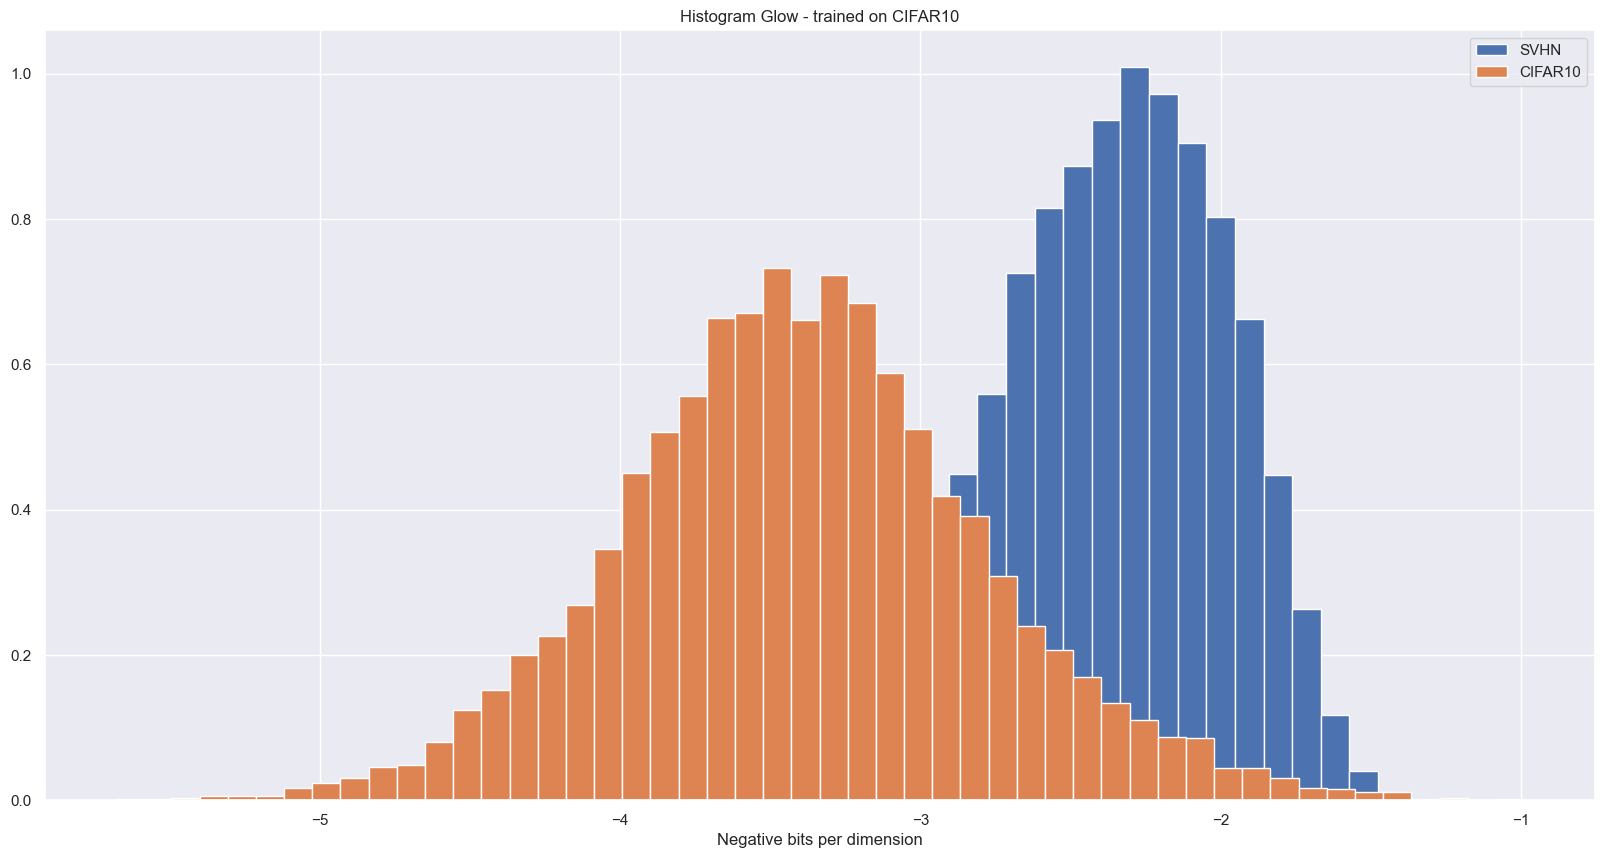

In [4]:
plt.figure(figsize=(20,10))
plt.title("Histogram Glow - trained on CIFAR10")
plt.xlabel("Negative bits per dimension")
plt.hist(-svhn_nll.numpy(), label="SVHN", density=True, bins=30)
plt.hist(-cifar_nll.numpy(), label="CIFAR10", density=True, bins=50)
plt.legend()
plt.show()
# plt.savefig("images/histogram_glow_cifar_svhn.png", dpi=300)